Test cross section modification with interpolation of intermediate bins for MCEq. The cross section is modifed at 3 nergies Ea, Eb, Ec and with factors a, b, c

In [1]:
import click
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
import matplotlib.lines as mlines
from scipy.interpolate import UnivariateSpline
from tqdm import tqdm
from MCEq.core import MCEqRun
import mceq_config as config
import crflux.models as pm
from MCEq.data import InteractionCrossSections
import sys
import os
import pickle
from scipy.stats import lognorm
from scipy.stats import norm

In [2]:

interactionmodel = "SIBYLL23C"
mceq_def = MCEqRun(
            interaction_model=interactionmodel,
            theta_deg=0.0,
            primary_model=(pm.HillasGaisser2012, "H3a"),
            density_model = (('MSIS00_IC',('SouthPole','January')))
        )

mceq_tune = MCEqRun(
            interaction_model=interactionmodel,
            theta_deg=0.0,
            primary_model=(pm.HillasGaisser2012, "H3a"),
            density_model = (('MSIS00_IC',('SouthPole','January')))
        )



MCEqRun::set_interaction_model(): SIBYLL23C
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to MSIS00_IC ('SouthPole', 'January')
MSIS00IceCubeCentered::set_theta(): latitude = -90.00 for zenith angle =  0.00
MCEqRun::set_primary_model(): HillasGaisser2012 H3a
MCEqRun::set_interaction_model(): SIBYLL23C
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to MSIS00_IC ('SouthPole', 'January')
MSIS00IceCubeCentered::set_theta(): latitude = -90.00 for zenith angle =  0.00
MCEqRun::set_primary_model(): HillasGaisser2012 H3a


In [3]:
cs_def = InteractionCrossSections(mceq_def._mceq_db, interaction_model=interactionmodel).get_cs(211, mbarn=True)

In [4]:
E = mceq_def.e_grid

In [5]:
Ea = 1.e3# GeV
Eb = 10.**4.5
Ec = 1.e6 # PeV

In [6]:
a = 0.05
b =0.1
c =0.1

In [7]:
w_a = 200
w_b= 200
w_c = 200

In [8]:
w_a=0.5

pdf_vals = norm.pdf(np.log10(E), loc=np.log10(Ea), scale=w_a)
# Rescale so that value at Ea is exactly a
pdf_vals *= a / norm.pdf(np.log10(Ea), loc=np.log10(Ea), scale=w_a)

In [9]:
def gauss_interp(E, E_m, w):
    pdf_vals = norm.pdf(np.log10(E), loc=np.log10(E_m), scale=w)
    pdf_vals *= a / norm.pdf(np.log10(E_m), loc=np.log10(E_m), scale=w)
    return pdf_vals


In [10]:
Ea = 10.**3.8
Eb = 10.**4.5
Ec = 10.**5.

w_a =0.3
w_b= 0.3
w_c = 0.3

a_values = gauss_interp(E, Ea, w_a)
b_values = gauss_interp(E, Eb, w_b)
c_values = gauss_interp(E, Ec, w_c)

Text(0, 0.5, 'Modification factor')

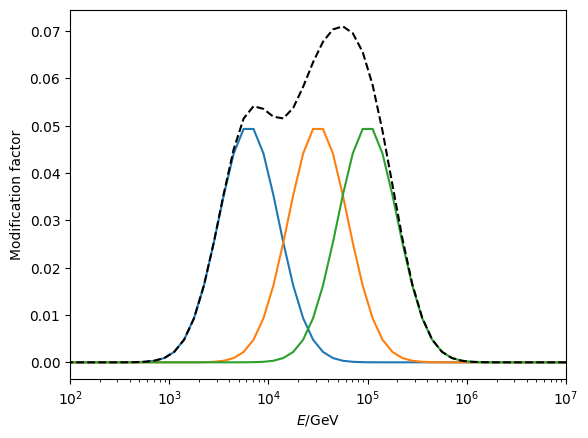

In [11]:
plt.plot(E,a_values)
plt.plot(E,b_values)
plt.plot(E,c_values)
plt.plot(E,a_values+b_values+c_values,color='black',ls='--')
plt.xscale('log')
plt.xlim(1.e2,1.e7)
plt.xlabel('$E$/GeV')
plt.ylabel('Modification factor')
#plt.ylim(0.99,1.1)

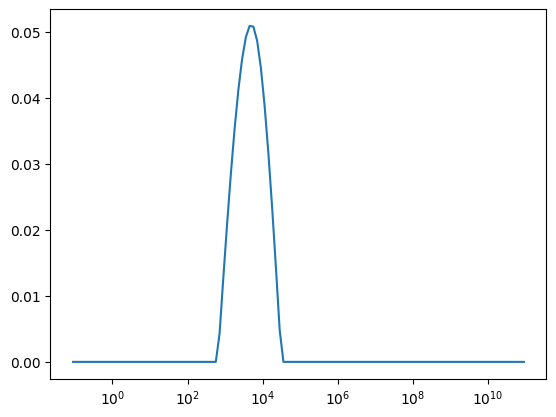

In [12]:
from scipy.interpolate import CubicSpline

knots = [2.8, np.log10(Ea),np.log10(Eb)]  # log10(E) positions
values = [0.0, a, 0.0]

cs = CubicSpline(knots, values, bc_type='natural')

bump = cs(np.log10(E))
bump[np.log10(E) < knots[0]] = 0.0
bump[np.log10(E) > knots[-1]] = 0.0

plt.plot(E, bump)
plt.xscale('log')

In [13]:
def spline_intp(E, Ek_1, Ek_c, E_k2, factor):
    knots = [np.log10(Ek_1), np.log10(Ek_c),np.log10(E_k2)]  # log10(E) positions
    values = [0.0, factor, 0.0]

    cs = CubicSpline(knots, values, bc_type='natural')

    bump = cs(np.log10(E))
    bump[np.log10(E) < knots[0]] = 0.0
    bump[np.log10(E) > knots[-1]] = 0.0
    return bump

In [14]:
Ea = 10.**3.2
Eb = 10.**4.5
Ec = 10.**5.

spline_vals_a = spline_intp(E, 800, Ea, Eb, a)
spline_vals_b = spline_intp(E, Ea, Eb, Ec, a)
spline_vals_c = spline_intp(E, Eb, Ec, 1.e6, a)


(100.0, 10000000.0)

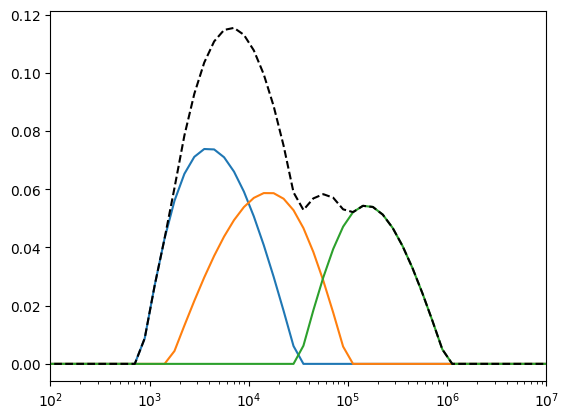

In [15]:
plt.plot(E, spline_vals_a)
plt.plot(E, spline_vals_b)
plt.plot(E, spline_vals_c)
plt.plot(E, spline_vals_a+spline_vals_b+spline_vals_c,color='black',ls='--')
plt.xscale('log')
plt.xlim(1.e2,1.e7)